In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('Joel\\datasets\\df_train_averaged_classification.csv')
df["labels"] = [[int(x) for x in l if x.isnumeric()] for l in df["labels"]]

In [ ]:
df.shape[0]

80

In [ ]:
df_str_labels = []
for z in range(0, df.shape[0]):
  str_labels = []
  if df['labels'][z][0] == 1:
    str_labels.append("neurotic")
  if df['labels'][z][1] == 1:
    str_labels.append("extravert")
  if df['labels'][z][2] == 1:
    str_labels.append("open")
  if df['labels'][z][3] == 1:
    str_labels.append("agreeable")
  if df['labels'][z][4] == 1:
    str_labels.append("conscious")

  df_str_labels.append(str_labels)

len(df_str_labels)

80

In [ ]:
x = list(df["text"])
y = df_str_labels
print(x[2])
print(y[2])

Bei einer Teststation beim Josef. Als ich mit meinem Freunden und meinem Schwarm Zeit verbracht habe. Ich habe heute nicht sehr viel produktives gemacht. Ich lache und lächle sehr viel, bin sehr sozial und freue mich über kleine Sachen. Mentale Gesundheit. Ich find sie vielen Facetten interessant. Ich räume mein Zimmer auf und ordne meine Sachen auf meinem Tisch, oft so, dass ich sie nicht mehr sehe. Ich würde raus gehen und auf einer Wiese picknicken, kuscheln, Spiele spielen und über Gott und die Welt reden
['neurotic', 'extravert', 'open', 'agreeable', 'conscious']


In [ ]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(80, 5)

In [ ]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[1 1 1 0 1]
[('agreeable', 'conscious', 'extravert', 'open')]
['agreeable' 'conscious' 'extravert' 'neurotic' 'open']


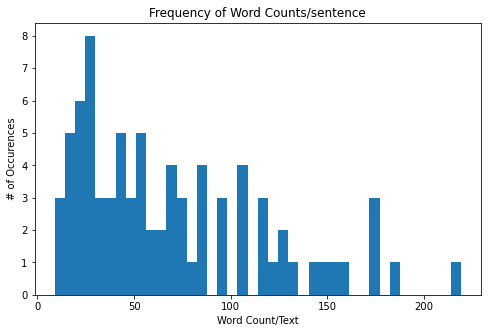

In [ ]:
# compute no. of words in each question
texts = x
word_cnt = [len(text.split()) for text in texts]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Text')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

## Split the dataset into training ,validation and test set.

In [ ]:
from sklearn.model_selection import train_test_split
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
len(x_tr) ,len(x_val), len(x_test)

(51, 13, 16)

## Preparing the Dataset and DataModule

In [ ]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }
        

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 4, num_workers=0)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 4, num_workers=0)

In [ ]:
# Initialize the Bert tokenizer
#BERT_MODEL_NAME = "bert-base-german-cased" 
BERT_MODEL_NAME = "bert-base-multilingual-cased"
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
max_word_cnt = 250
text_cnt = 0

# For every sentence...
for text in texts:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        text_cnt +=1

print(f'# Text having word count > {max_word_cnt}: is  {text_cnt}')

# Text having word count > 250: is  6


In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 12
MAX_LEN = 250
LR = 2e-05

In [ ]:
print(x_tr)

['Joseph. Wie sich jemand vom E-Roller hingelegt hat. Zu leben. Befriedigend. James-Webb-Teleskop und Jojos Bizzare Adventure ein wahres Meisterwerk aus dem japanischen Raum. Keine Aussage. Ehrlich gesagt zur Zeit habe ich echt einen miesen Crush auf eine aber die Situation ist schwierig ich möchte mit ihr Ramen essen gehen und dann einfach einen lustigen Tag erleben weil das haben wir schon mal aber ich fande das Erlebnis schön nur ich weiß nicht in welche Richtung es geht', 'Link. Bei der Gitarren-Impro eines Freundes am Lagerfeuer. Ich habe das Arbeitstreffen erledigen können.. Ich bin dann energiegeladen und gut gelaunt :-). Umweltschutz, Krieg, seltene Erden, fairer Handel. Putzen, Strukturen schaffen (physische Ordnung aber auch Zeitmanagement/Termine legen), Routinen. Eine ehrliche Einladung zu einem Date ohne viel Tamtam, gern auch in die Planung involviert zu sein. Das perfekte Date könnte ein Spaziergang am See sein mit einer Picknickdecke und was zum Snacken plus ein kühles 

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

## Train the model

In [ ]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=5, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [ ]:
# Instantiate the classifier model
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=5, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback])

C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 177 M 
1 | classifier | Linear            | 3.8 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.429   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1891: PossibleUserWarning: The number of training batches (5) is smaller than the logg

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [ ]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.738318681716919     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.738318681716919}]

In [ ]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Evaluate Model Performance on Test Set

In [ ]:
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

'C:\\Users\\Max\\lightning_logs\\version_2\\checkpoints\\QTag-epoch=01-val_loss=0.69.ckpt'

In [ ]:
len(y_test), len(x_test)

(16, 16)

In [ ]:
# Size of Test set
print(f'Number of texts = {len(x_test)}')

Number of texts = 16


## setup test dataset for BERT

In [ ]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 8  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)
    

## Prediction on test set

In [ ]:
flat_pred_outs = 0
flat_true_labels = 0

In [ ]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [ ]:
pred_outs[0][0]

array([0.78653467, 0.70667166, 0.7289358 , 0.18481518, 0.4770203 ],
      dtype=float32)

In [ ]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
flat_pred_outs.shape , flat_true_labels.shape

((16, 5), (16, 5))

## Predictions of Tags in Test set
The predictions are in terms of logits (probabilities for each of the 16 tags). Hence we need to have a threshold value to convert these probabilities to 0 or 1.

Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the test set.

In [ ]:
#define candidate threshold values
threshold  = np.arange(0.4,0.7,0.01)
threshold

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,
       0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69])

In [ ]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [ ]:
flat_pred_outs[3]

array([0.18684973, 0.249306  , 0.30840942, 0.8433304 , 0.5175805 ],
      dtype=float32)

In [ ]:
flat_true_labels[3]

array([1, 0, 1, 1, 1])

In [ ]:
flat_pred_outs[10]

array([0.37699202, 0.4077958 , 0.48395717, 0.60745686, 0.4251937 ],
      dtype=float32)

In [ ]:
flat_true_labels[10]

array([1, 0, 0, 1, 0])

In [ ]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [ ]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

Optimal Threshold Value = 0.4


## Performance Score Evaluation

In [ ]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [ ]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.22      0.25        32
           1       0.56      0.67      0.61        48

    accuracy                           0.49        80
   macro avg       0.43      0.44      0.43        80
weighted avg       0.46      0.49      0.47        80



In [ ]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [ ]:
df.sample(10)

,Body,Actual Tags,Predicted Tags
0,Ich bin hier einfach reingelaufen. An einem Ab...,"(agreeable, extravert, open)","(agreeable, conscious, extravert, open)"
1,Arbeitskollegin. Auf einer Hochzeit. Seife gek...,"(agreeable, conscious, extravert, open)","(agreeable, conscious, extravert, open)"
5,Habe dich im JOSEPHS entdeckt!. Bei roten Pand...,"(agreeable, conscious, extravert, open)","(agreeable, conscious, extravert, open)"
14,kollegen. witz von kollegen. Arbeiten. bin gut...,"(agreeable,)","(agreeable, conscious, extravert, neurotic, open)"
13,"In einen Technikladen, an einem Museum. Auf Ti...","(agreeable, conscious, extravert, open)","(agreeable, conscious, extravert, neurotic)"
11,Ich habe da so einen Link bekommen.. Das will ...,"(conscious, extravert, neurotic)","(neurotic, open)"
8,"Besuch im Josephs. Keine konkrete Erinnerung, ...","(agreeable, conscious, extravert)","(extravert, neurotic)"
9,Durch das JOSEPHS. Als ich auf dem Annafest ge...,"(agreeable, conscious, extravert)","(neurotic, open)"
2,Durch meine Arbeit. Bei einem Treffen mit Freu...,"(agreeable, neurotic, open)","(agreeable, conscious, extravert, open)"
15,Leonardo. Mein freund und ich haben eine witzi...,"(agreeable, extravert, neurotic, open)","(agreeable, conscious, extravert, neurotic, open)"
